## Importing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller
import pickle
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.4f}'.format
from sklearn.preprocessing import LabelEncoder

## Loading Dataset

In [5]:
train_data = pd.read_csv(r"C:\Users\asus\Downloads\train (1).csv")
oil_data = pd.read_csv(r"C:\Users\asus\Downloads\data\oil.csv")

## Convert into Date-Time Format

In [8]:
train_data['date'] = pd.to_datetime(train_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])

## Filling Missing Values

In [11]:
oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(method='bfill')
oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(method='ffill')
oil_data

,date,dcoilwtico
0,2020-01-01,93.1400
1,2020-01-02,93.1400
2,2020-01-03,92.9700
3,2020-01-04,93.1200
4,2020-01-07,93.2000
...,...,...
1049,2024-01-09,51.9500
1050,2024-01-10,50.8200
1051,2024-01-11,52.1900
1052,2024-01-12,53.0100


## Merge Train Data with Oil Data

In [14]:
merged_data = pd.merge(train_data, oil_data, on='date', how='left')
merged_data['family'] = merged_data['family'].replace('BREAD/BAKERY', 'BREAD_BAKERY')
merged_data['dcoilwtico'] = merged_data['dcoilwtico'].fillna(method='bfill')
merged_data['dcoilwtico'] = merged_data['dcoilwtico'].fillna(method='ffill')
merged_data

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2020-01-01,1,AUTOMOTIVE,0.0000,0,93.1400
1,1,2020-01-01,1,BABY CARE,0.0000,0,93.1400
2,2,2020-01-01,1,BEAUTY,0.0000,0,93.1400
3,3,2020-01-01,1,BEVERAGES,0.0000,0,93.1400
4,4,2020-01-01,1,BOOKS,0.0000,0,93.1400
...,...,...,...,...,...,...,...
2596369,2596369,2023-12-31,9,POULTRY,687.8530,1,53.7500
2596370,2596370,2023-12-31,9,PREPARED FOODS,100.4050,1,53.7500
2596371,2596371,2023-12-31,9,PRODUCE,"3,091.3560",3,53.7500
2596372,2596372,2023-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.0000,0,53.7500


## Exploratory Data Analysis

### Checking Missing Values

In [18]:
merged_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64

In [20]:
merged_data.drop(columns = ["id", "onpromotion"], inplace = True)
merged_data

,date,store_nbr,family,sales,dcoilwtico
0,2020-01-01,1,AUTOMOTIVE,0.0000,93.1400
1,2020-01-01,1,BABY CARE,0.0000,93.1400
2,2020-01-01,1,BEAUTY,0.0000,93.1400
3,2020-01-01,1,BEVERAGES,0.0000,93.1400
4,2020-01-01,1,BOOKS,0.0000,93.1400
...,...,...,...,...,...
2596369,2023-12-31,9,POULTRY,687.8530,53.7500
2596370,2023-12-31,9,PREPARED FOODS,100.4050,53.7500
2596371,2023-12-31,9,PRODUCE,"3,091.3560",53.7500
2596372,2023-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.0000,53.7500


In [22]:
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2596374 entries, 0 to 2596373
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   store_nbr   int64         
 2   family      object        
 3   sales       float64       
 4   dcoilwtico  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 99.0+ MB
None


In [24]:
print(merged_data.describe())

                                date      store_nbr          sales  \
count                        2596374 2,596,374.0000 2,596,374.0000   
mean   2021-12-31 06:24:27.673301248        27.5000       338.7139   
min              2020-01-01 00:00:00         1.0000         0.0000   
25%              2021-01-01 00:00:00        14.0000         0.0000   
50%              2022-01-01 00:00:00        27.5000         9.0000   
75%              2023-01-01 00:00:00        41.0000       184.0608   
max              2023-12-31 00:00:00        54.0000   124,717.0000   
std                              NaN        15.5858     1,055.8287   

          dcoilwtico  
count 2,596,374.0000  
mean         70.7374  
min          26.1900  
25%          46.2100  
50%          60.0100  
75%          97.0000  
max         110.6200  
std          26.4728  


In [26]:
print(merged_data['family'].nunique(), "unique product families")

33 unique product families


In [28]:

print(merged_data['store_nbr'].nunique(), "unique stores")

54 unique stores


### Sales Over Time (Total)

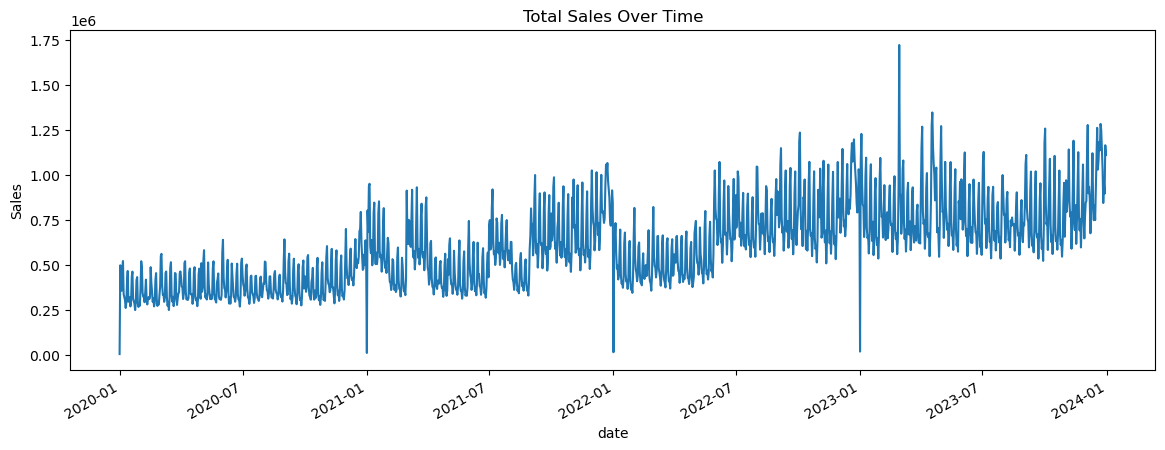

In [31]:
merged_data.groupby('date')['sales'].sum().plot(figsize=(14, 5))
plt.title("Total Sales Over Time")
plt.ylabel("Sales")
plt.show()

### Oil Price Over Time

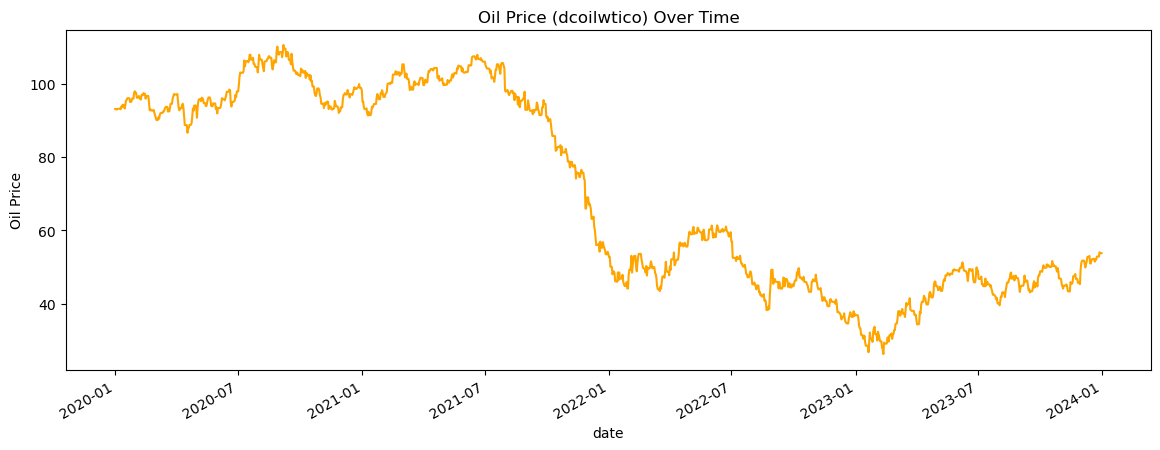

In [34]:
merged_data.groupby('date')['dcoilwtico'].mean().plot(figsize=(14, 5), color='orange')
plt.title("Oil Price (dcoilwtico) Over Time")
plt.ylabel("Oil Price")
plt.show()

### Sales by Store

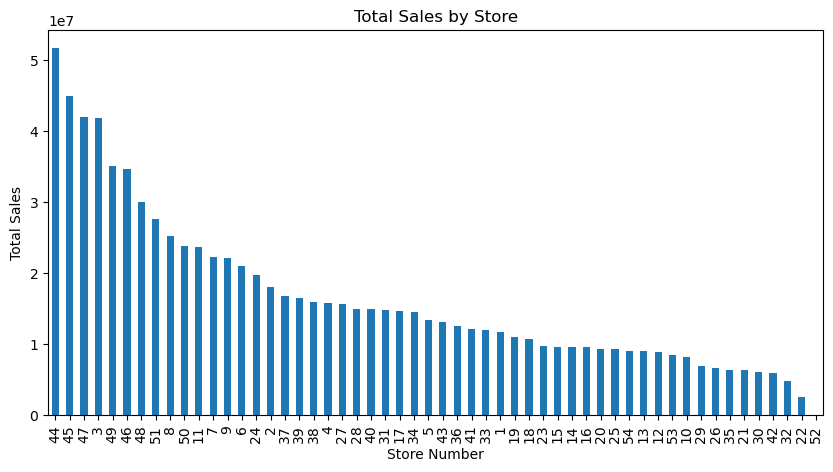

In [37]:
store_sales = merged_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)
store_sales.plot(kind='bar', figsize=(10,5))
plt.title("Total Sales by Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.show()

### Sales by Product Family

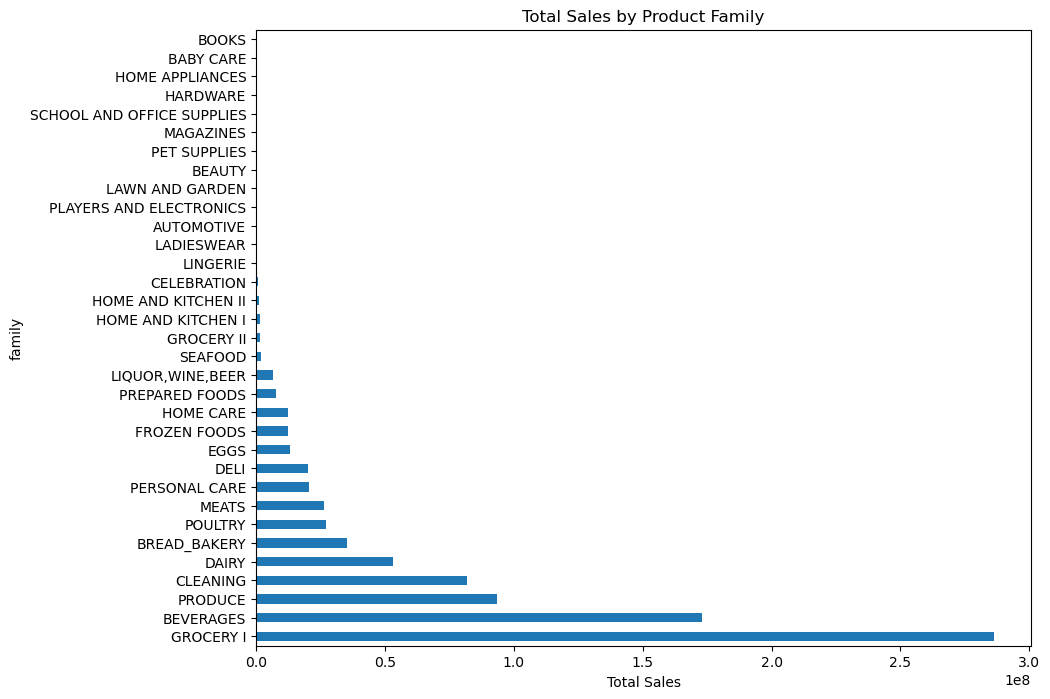

In [40]:
family_sales = merged_data.groupby('family')['sales'].sum().sort_values(ascending=False)
family_sales.plot(kind='barh', figsize=(10, 8))
plt.title("Total Sales by Product Family")
plt.xlabel("Total Sales")
plt.show()

### Relationship Between Sales & Oil Prices

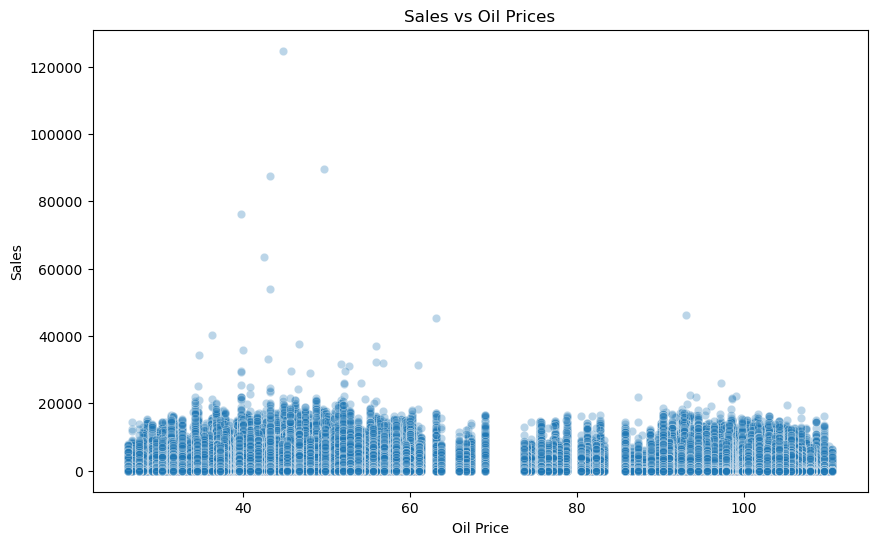

In [43]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_data, x='dcoilwtico', y='sales', alpha=0.3)
plt.title("Sales vs Oil Prices")
plt.xlabel("Oil Price")
plt.ylabel("Sales")
plt.show()

### Correlation Matrix

In [46]:
merged_data[['sales', 'dcoilwtico']].corr()

,sales,dcoilwtico
sales,1.0000,-0.0733
dcoilwtico,-0.0733,1.0000


## Splitting Date Yearly, Monthly, and Quarterly

In [49]:
merged_data["Year"] = merged_data["date"].dt.year
merged_data["Month"] = merged_data["date"].dt.month
merged_data["Quarter"] = merged_data["date"].dt.quarter
merged_data

,date,store_nbr,family,sales,dcoilwtico,Year,Month,Quarter
0,2020-01-01,1,AUTOMOTIVE,0.0000,93.1400,2020,1,1
1,2020-01-01,1,BABY CARE,0.0000,93.1400,2020,1,1
2,2020-01-01,1,BEAUTY,0.0000,93.1400,2020,1,1
3,2020-01-01,1,BEVERAGES,0.0000,93.1400,2020,1,1
4,2020-01-01,1,BOOKS,0.0000,93.1400,2020,1,1
...,...,...,...,...,...,...,...,...
2596369,2023-12-31,9,POULTRY,687.8530,53.7500,2023,12,4
2596370,2023-12-31,9,PREPARED FOODS,100.4050,53.7500,2023,12,4
2596371,2023-12-31,9,PRODUCE,"3,091.3560",53.7500,2023,12,4
2596372,2023-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.0000,53.7500,2023,12,4


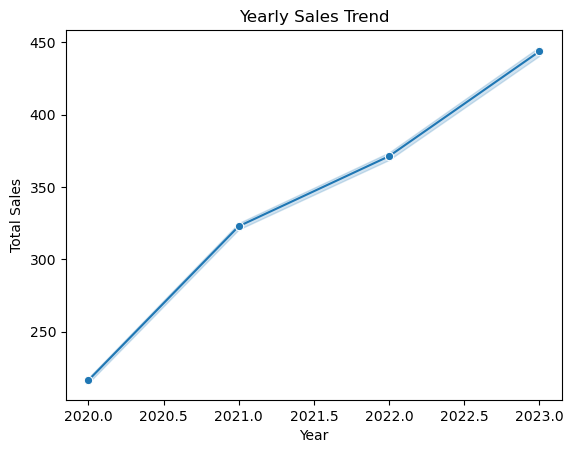

In [52]:
sns.lineplot(data=merged_data, x='Year', y='sales', marker='o')
plt.title("Yearly Sales Trend")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.show()

## Monthly Sales

In [52]:
merged_data["Year-Month"] = merged_data["Year"].astype(str) + "-" + merged_data["Month"].astype(str).str.zfill(2)
merged_data

,date,store_nbr,family,sales,dcoilwtico,Year,Month,Quarter,Year-Month
0,2020-01-01,1,AUTOMOTIVE,0.0000,93.1400,2020,1,1,2020-01
1,2020-01-01,1,BABY CARE,0.0000,93.1400,2020,1,1,2020-01
2,2020-01-01,1,BEAUTY,0.0000,93.1400,2020,1,1,2020-01
3,2020-01-01,1,BEVERAGES,0.0000,93.1400,2020,1,1,2020-01
4,2020-01-01,1,BOOKS,0.0000,93.1400,2020,1,1,2020-01
...,...,...,...,...,...,...,...,...,...
2596369,2023-12-31,9,POULTRY,687.8530,53.7500,2023,12,4,2023-12
2596370,2023-12-31,9,PREPARED FOODS,100.4050,53.7500,2023,12,4,2023-12
2596371,2023-12-31,9,PRODUCE,"3,091.3560",53.7500,2023,12,4,2023-12
2596372,2023-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.0000,53.7500,2023,12,4,2023-12


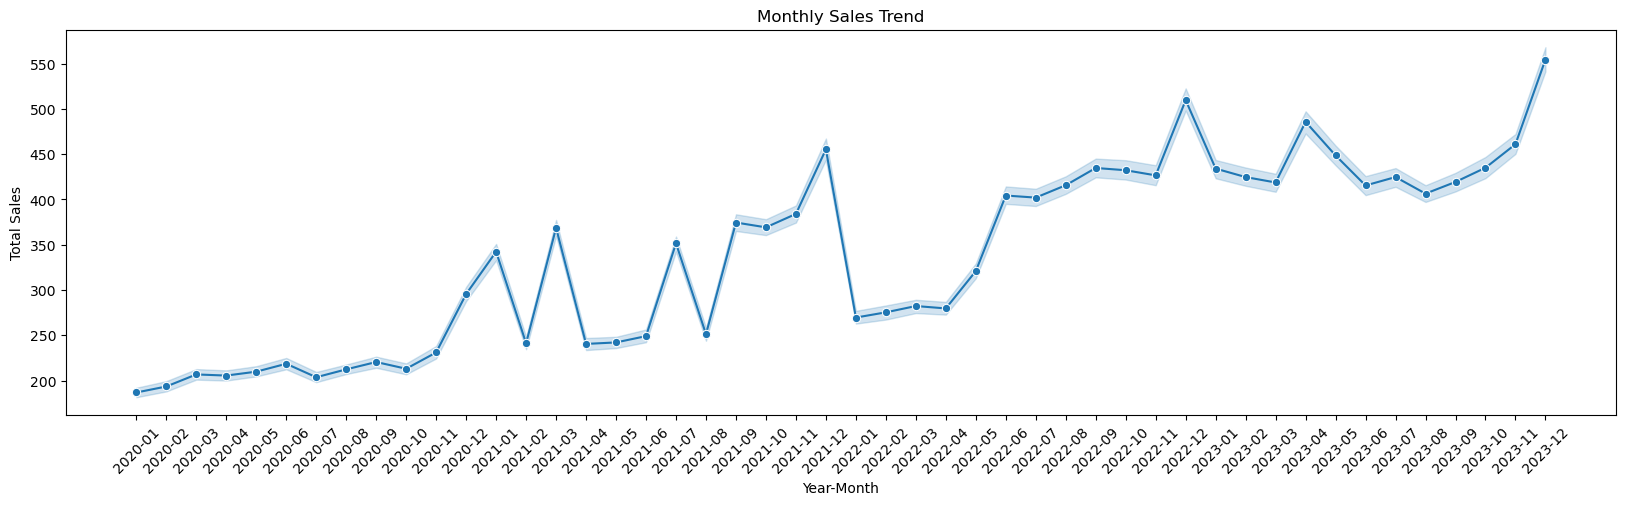

In [57]:
plt.figure(figsize = (20,5))
sns.lineplot(data=merged_data, x='Year-Month', y='sales', marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Year-Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

## Quarterly Sales

In [54]:
merged_data["Year-Quarter"] = merged_data["Year"].astype(str) + "-" + merged_data["Quarter"].astype(str).str.zfill(2)
merged_data

,date,store_nbr,family,sales,dcoilwtico,Year,Month,Quarter,Year-Month,Year-Quarter
0,2020-01-01,1,AUTOMOTIVE,0.0000,93.1400,2020,1,1,2020-01,2020-01
1,2020-01-01,1,BABY CARE,0.0000,93.1400,2020,1,1,2020-01,2020-01
2,2020-01-01,1,BEAUTY,0.0000,93.1400,2020,1,1,2020-01,2020-01
3,2020-01-01,1,BEVERAGES,0.0000,93.1400,2020,1,1,2020-01,2020-01
4,2020-01-01,1,BOOKS,0.0000,93.1400,2020,1,1,2020-01,2020-01
...,...,...,...,...,...,...,...,...,...,...
2596369,2023-12-31,9,POULTRY,687.8530,53.7500,2023,12,4,2023-12,2023-04
2596370,2023-12-31,9,PREPARED FOODS,100.4050,53.7500,2023,12,4,2023-12,2023-04
2596371,2023-12-31,9,PRODUCE,"3,091.3560",53.7500,2023,12,4,2023-12,2023-04
2596372,2023-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.0000,53.7500,2023,12,4,2023-12,2023-04


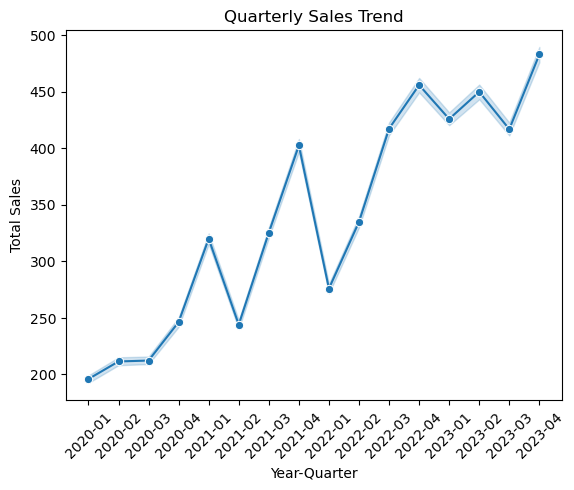

In [62]:
sns.lineplot(data=merged_data, x='Year-Quarter', y='sales', marker='o')
plt.title("Quarterly Sales Trend")
plt.xlabel("Year-Quarter")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

## Group By:

In [161]:
df = merged_data.groupby(["Year", "Quarter", "family"], as_index = False).agg({"sales" : "sum","dcoilwtico" : "mean" })
df

,Year,Quarter,family,sales,dcoilwtico
0,2020,1,AUTOMOTIVE,"21,412.0000",94.4666
1,2020,1,BABY CARE,0.0000,94.4666
2,2020,1,BEAUTY,"11,667.0000",94.4666
3,2020,1,BEVERAGES,"5,001,127.0000",94.4666
4,2020,1,BOOKS,0.0000,94.4666
...,...,...,...,...,...
523,2023,4,POULTRY,"1,966,067.5634",49.1047
524,2023,4,PREPARED FOODS,"516,604.2458",49.1047
525,2023,4,PRODUCE,"11,354,309.3796",49.1047
526,2023,4,SCHOOL AND OFFICE SUPPLIES,"7,721.0000",49.1047


## Sort Index Quarterly

In [164]:
df['quarter_start'] = pd.PeriodIndex(year=df['Year'], quarter=df['Quarter'], freq='Q').start_time

df.set_index('quarter_start', inplace=True)

df.sort_index(inplace=True)
df

,Year,Quarter,family,sales,dcoilwtico
quarter_start,,,,,
2020-01-01,2020,1,AUTOMOTIVE,"21,412.0000",94.4666
2020-01-01,2020,1,BABY CARE,0.0000,94.4666
2020-01-01,2020,1,BEAUTY,"11,667.0000",94.4666
2020-01-01,2020,1,BEVERAGES,"5,001,127.0000",94.4666
2020-01-01,2020,1,BOOKS,0.0000,94.4666
...,...,...,...,...,...
2023-10-01,2023,4,POULTRY,"1,966,067.5634",49.1047
2023-10-01,2023,4,PREPARED FOODS,"516,604.2458",49.1047
2023-10-01,2023,4,PRODUCE,"11,354,309.3796",49.1047


In [166]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'family' column
df['family_encoded'] = le.fit_transform(df['family'])

# Create a mapping dictionary
family_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the mapping
print("Category to Label Mapping:")
for category, label in family_mapping.items():
    print(f"{category}: {label}")

df

Category to Label Mapping:
AUTOMOTIVE: 0
BABY CARE: 1
BEAUTY: 2
BEVERAGES: 3
BOOKS: 4
BREAD_BAKERY: 5
CELEBRATION: 6
CLEANING: 7
DAIRY: 8
DELI: 9
EGGS: 10
FROZEN FOODS: 11
GROCERY I: 12
GROCERY II: 13
HARDWARE: 14
HOME AND KITCHEN I: 15
HOME AND KITCHEN II: 16
HOME APPLIANCES: 17
HOME CARE: 18
LADIESWEAR: 19
LAWN AND GARDEN: 20
LINGERIE: 21
LIQUOR,WINE,BEER: 22
MAGAZINES: 23
MEATS: 24
PERSONAL CARE: 25
PET SUPPLIES: 26
PLAYERS AND ELECTRONICS: 27
POULTRY: 28
PREPARED FOODS: 29
PRODUCE: 30
SCHOOL AND OFFICE SUPPLIES: 31
SEAFOOD: 32


,Year,Quarter,family,sales,dcoilwtico,family_encoded
quarter_start,,,,,,
2020-01-01,2020,1,AUTOMOTIVE,"21,412.0000",94.4666,0
2020-01-01,2020,1,BABY CARE,0.0000,94.4666,1
2020-01-01,2020,1,BEAUTY,"11,667.0000",94.4666,2
2020-01-01,2020,1,BEVERAGES,"5,001,127.0000",94.4666,3
2020-01-01,2020,1,BOOKS,0.0000,94.4666,4
...,...,...,...,...,...,...
2023-10-01,2023,4,POULTRY,"1,966,067.5634",49.1047,28
2023-10-01,2023,4,PREPARED FOODS,"516,604.2458",49.1047,29
2023-10-01,2023,4,PRODUCE,"11,354,309.3796",49.1047,30


In [168]:
df.drop("family", axis = 1, inplace = True)
df

df.to_csv("Cleaned_Data.csv")

## Differencing Data Quarterly

In [171]:
df["sales_lag"] = df["sales"].diff(33)
df

,Year,Quarter,sales,dcoilwtico,family_encoded,sales_lag
quarter_start,,,,,,
2020-01-01,2020,1,"21,412.0000",94.4666,0,NaN
2020-01-01,2020,1,0.0000,94.4666,1,NaN
2020-01-01,2020,1,"11,667.0000",94.4666,2,NaN
2020-01-01,2020,1,"5,001,127.0000",94.4666,3,NaN
2020-01-01,2020,1,0.0000,94.4666,4,NaN
...,...,...,...,...,...,...
2023-10-01,2023,4,"1,966,067.5634",49.1047,28,"143,668.9392"
2023-10-01,2023,4,"516,604.2458",49.1047,29,"7,664.2459"
2023-10-01,2023,4,"11,354,309.3796",49.1047,30,"827,308.8577"


## Dropping Null Values

In [174]:
df.dropna(inplace = True)
df

,Year,Quarter,sales,dcoilwtico,family_encoded,sales_lag
quarter_start,,,,,,
2020-04-01,2020,2,"24,830.0000",94.1429,0,"3,418.0000"
2020-04-01,2020,2,0.0000,94.1429,1,0.0000
2020-04-01,2020,2,"11,228.0000",94.1429,2,-439.0000
2020-04-01,2020,2,"5,396,350.0000",94.1429,3,"395,223.0000"
2020-04-01,2020,2,0.0000,94.1429,4,0.0000
...,...,...,...,...,...,...
2023-10-01,2023,4,"1,966,067.5634",49.1047,28,"143,668.9392"
2023-10-01,2023,4,"516,604.2458",49.1047,29,"7,664.2459"
2023-10-01,2023,4,"11,354,309.3796",49.1047,30,"827,308.8577"


In [176]:
df["Year-Quarter"] = df["Year"].astype(str) + "-" + df["Quarter"].astype(str).str.zfill(2)
df

,Year,Quarter,sales,dcoilwtico,family_encoded,sales_lag,Year-Quarter
quarter_start,,,,,,,
2020-04-01,2020,2,"24,830.0000",94.1429,0,"3,418.0000",2020-02
2020-04-01,2020,2,0.0000,94.1429,1,0.0000,2020-02
2020-04-01,2020,2,"11,228.0000",94.1429,2,-439.0000,2020-02
2020-04-01,2020,2,"5,396,350.0000",94.1429,3,"395,223.0000",2020-02
2020-04-01,2020,2,0.0000,94.1429,4,0.0000,2020-02
...,...,...,...,...,...,...,...
2023-10-01,2023,4,"1,966,067.5634",49.1047,28,"143,668.9392",2023-04
2023-10-01,2023,4,"516,604.2458",49.1047,29,"7,664.2459",2023-04
2023-10-01,2023,4,"11,354,309.3796",49.1047,30,"827,308.8577",2023-04


## Checking Seasonality After Differencing

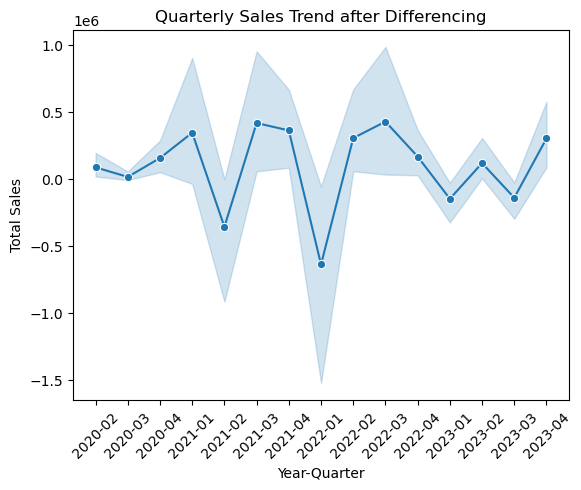

In [179]:
sns.lineplot(data=df, x='Year-Quarter', y='sales_lag', marker='o')
plt.title("Quarterly Sales Trend after Differencing")
plt.xlabel("Year-Quarter")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

In [181]:
df.to_csv("Differencing_1.csv")

## Checking Stationarity using Augmented Dickey-Fuller Test

In [184]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])

    if result[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")

# Example usage
check_stationarity(df['sales_lag'])

ADF Statistic: -9.966937012191245
p-value: 2.2937883409570914e-17
Critical Values: {'1%': -3.4437936797256317, '5%': -2.867468682890213, '10%': -2.5699277594606915}
The time series is stationary.


## Checking Homoscedasticity using ARCH

In [187]:
# Perform the ARCH test
arch_test = het_arch(df['sales_lag'])

print("ARCH Test Statistic:", arch_test[0])
print("p-value:", arch_test[1])

# Interpretation
if arch_test[1] < 0.05:
    print("Heteroscedasticity detected")
else:
    print("Homoscedasticity detected")

ARCH Test Statistic: 13.987843793358284
p-value: 0.17354681263428837
Homoscedasticity detected


## Dropping rows containing INF and NaN Values

In [190]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.isnull().sum()

Year              0
Quarter           0
sales             0
dcoilwtico        0
family_encoded    0
sales_lag         0
Year-Quarter      0
dtype: int64

In [192]:
df.shape

(495, 7)

In [194]:
df.drop(columns = ["sales", "Year-Quarter"], inplace = True)
df

,Year,Quarter,dcoilwtico,family_encoded,sales_lag
quarter_start,,,,,
2020-04-01,2020,2,94.1429,0,"3,418.0000"
2020-04-01,2020,2,94.1429,1,0.0000
2020-04-01,2020,2,94.1429,2,-439.0000
2020-04-01,2020,2,94.1429,3,"395,223.0000"
2020-04-01,2020,2,94.1429,4,0.0000
...,...,...,...,...,...
2023-10-01,2023,4,49.1047,28,"143,668.9392"
2023-10-01,2023,4,49.1047,29,"7,664.2459"
2023-10-01,2023,4,49.1047,30,"827,308.8577"


## Splitting Data for Training and Testing

In [197]:
train_size = int(0.8*len(df))
X_train = df.iloc[:train_size].copy()
Y_train = X_train.pop("sales_lag")

X_test = df.iloc[train_size:].copy()
Y_test = X_test.pop("sales_lag")

In [199]:
X_train.shape

(396, 4)

In [201]:
X_test.shape

(99, 4)

## Getting ACF and PACF values

In [204]:
target = df['sales_lag']

max_lag = 33

acf_vals = acf(target, nlags=max_lag)
pacf_vals = pacf(target, nlags=max_lag)

lags = np.arange(max_lag + 1)
acf_pacf_temp_monthly = pd.DataFrame({'Lag': lags, 'ACF': acf_vals, 'PACF': pacf_vals})

print(acf_pacf_temp_monthly)

    Lag     ACF    PACF
0     0  1.0000  1.0000
1     1  0.0252  0.0252
2     2  0.0096  0.0090
3     3  0.0041  0.0037
4     4  0.0231  0.0230
5     5  0.0212  0.0203
6     6 -0.1451 -0.1485
7     7 -0.0030  0.0042
8     8 -0.0002  0.0023
9     9  0.0655  0.0682
10   10 -0.0038 -0.0013
11   11 -0.0033  0.0018
12   12  0.0730  0.0534
13   13 -0.0001 -0.0068
14   14  0.0107  0.0071
15   15  0.0894  0.1138
16   16 -0.0010 -0.0109
17   17 -0.0084 -0.0147
18   18  0.0428  0.0601
19   19  0.0053 -0.0027
20   20 -0.0080 -0.0121
21   21 -0.0433 -0.0244
22   22  0.0097  0.0109
23   23  0.0101  0.0043
24   24 -0.0258 -0.0331
25   25  0.0046  0.0122
26   26 -0.0052 -0.0056
27   27  0.3929  0.4024
28   28 -0.0069 -0.0329
29   29 -0.0165 -0.0269
30   30 -0.0093 -0.0403
31   31 -0.0055 -0.0219
32   32 -0.0186 -0.0433
33   33 -0.3609 -0.3397


## Plotting ACF and PACF

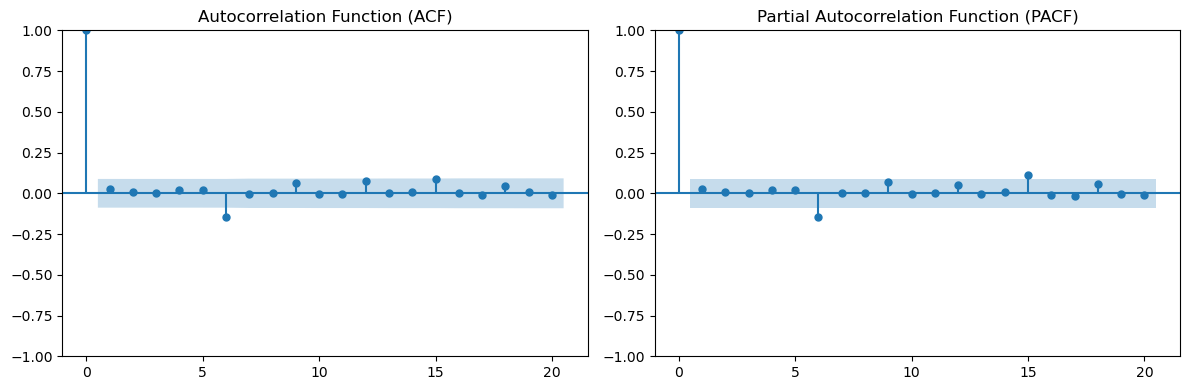

In [207]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_acf(df['sales_lag'], ax=axes[0], lags=20)
axes[0].set_title('Autocorrelation Function (ACF)')


plot_pacf(df['sales_lag'], ax=axes[1], lags=20)
axes[1].set_title('Partial Autocorrelation Function (PACF)')


plt.tight_layout()
plt.show()

In [209]:
df['sales_lag'].describe()

count           495.0000
mean         94,743.9112
std       1,045,943.2266
min     -10,250,091.0875
25%          -1,827.5000
50%           1,244.0000
75%          39,661.5496
max       7,207,902.7638
Name: sales_lag, dtype: float64

## Applying SARIMAX

In [212]:
model = SARIMAX(Y_train, exog=X_train, order=(6, 0, 6))  # adjust (p,d,q) based on AIC/BIC/grid search
model_fit = model.fit(disp=False)

# Forecast
pred = model_fit.predict(start=len(Y_train), end=len(Y_train)+len(Y_test)-1, exog=X_test)

# Optional: evaluate model
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(Y_test, pred))
print("RMSE:", rmse)

RMSE: 639050.4538762666


## Applying SARIMAX by Product Family

In [215]:
rms = {}
error = []
adequacy = {}
adequacy["Max"] = []
adequacy["Min"] = []
adequacy["RMSE"] = []
adequacy["RMSE_Ratio"] = []


for family in df['family_encoded'].unique():
    
    try:
        temp_df = df[df["family_encoded"] == family]
        train_value = int(0.8*len(temp_df))
        X_train = temp_df.iloc[:train_value].copy()
        Y_train = X_train.pop("sales_lag")
    
        model = SARIMAX(Y_train, exog=X_train, order=(6, 1, 6), enforce_stationarity=False)  # adjust (p,d,q) based on AIC/BIC/grid search
        model_fit = model.fit()

        X_test = temp_df.iloc[train_value:].copy()
        Y_test = X_test.pop("sales_lag")
        
        
        Y_pred = model_fit.predict(start=len(Y_train), end=len(Y_train)+len(Y_test)-1, exog=X_test)

        
        
        rmse = np.sqrt(mean_squared_error(Y_pred, Y_test))

        mean_sales = temp_df['sales_lag'].mean()
        rmse_ratio = rmse / mean_sales
        adequacy["RMSE_Ratio"].append(rmse_ratio)
        adequacy["Max"].append(temp_df['sales_lag'].max())
        adequacy["Min"].append(temp_df['sales_lag'].min())
        

        print(f"{family}done...")
        adequacy["RMSE"].append(rmse)
        
    except:
        error.append(family)
        pass 

0done...
1done...
2done...
3done...
4done...
5done...
6done...
7done...
8done...
9done...
10done...
11done...
12done...
13done...
14done...
15done...
16done...
17done...
18done...
19done...
20done...
21done...
22done...
23done...
24done...
25done...
26done...
27done...
28done...
29done...
30done...
31done...
32done...


## Checking Model Adequacy

In [217]:
data_frame = pd.DataFrame(adequacy)
data_frame

,Max,Min,RMSE,RMSE_Ratio
0,"6,517.0000","-2,956.0000","2,831.3890",3.3879
1,926.0000,-832.0000,521.3647,5.5347
2,"5,901.0000","-3,937.0000","4,222.7258",3.5445
3,"4,543,100.0000","-6,784,893.0000","4,387,117.5931",5.5506
4,"4,119.0000",0.0000,"2,378.1058",8.6603
5,"430,127.1401","-150,807.3087","123,876.6208",1.9591
6,"48,801.0000","-61,302.0000","34,977.4479",7.0603
7,"565,941.0000","-362,573.0000","615,558.6632",5.3067
8,"895,388.0000","-217,301.0000","284,961.2107",1.4804
9,"155,230.6540","-131,518.0310","203,463.7953",4.8286


## Predicting Sales by Product Family

In [221]:
predictions = []  # to store results

for family in df['family_encoded'].unique():
    try:
        temp_df = df[df["family_encoded"] == family]
        train_value = int(0.8 * len(temp_df))
        X_train = temp_df.iloc[:train_value].copy()
        Y_train = X_train.pop("sales_lag")

        model = SARIMAX(Y_train, exog=X_train, order=(6, 1, 6), enforce_stationarity=False)
        model_fit = model.fit(disp=False)

        X_test = temp_df.iloc[train_value:].copy()
        Y_test = X_test.pop("sales_lag")

        Y_pred = model_fit.predict(
            start=len(Y_train),
            end=len(Y_train) + len(Y_test) - 1,
            exog=X_test
        )

        # Extract corresponding date info from X_test
        test_dates = X_test.index

        for date, pred in zip(test_dates, Y_pred):
            year = pd.to_datetime(date).year
            quarter = pd.to_datetime(date).quarter
            predictions.append({
                'family': family,
                'year': year,
                'quarter': quarter,
                'prediction': pred
            })

        print(f"{family} done...")

    except Exception as e:
        error.append(family)
        print(f"Error in {family}: {e}")
        pass


0 done...
1 done...
2 done...
3 done...
4 done...
5 done...
6 done...
7 done...
8 done...
9 done...
10 done...
11 done...
12 done...
13 done...
14 done...
15 done...
16 done...
17 done...
18 done...
19 done...
20 done...
21 done...
22 done...
23 done...
24 done...
25 done...
26 done...
27 done...
28 done...
29 done...
30 done...
31 done...
32 done...


## Creating Data Frame for Predicted Sales

In [224]:
pred_df = pd.DataFrame(predictions)
pred_df

,family,year,quarter,prediction
0,0,2023,2,-803.5572
1,0,2023,3,-755.9646
2,0,2023,4,"-1,676.1854"
3,1,2023,2,708.8533
4,1,2023,3,591.0062
...,...,...,...,...
94,31,2023,3,"17,939.5781"
95,31,2023,4,"12,829.6736"
96,32,2023,2,"-2,223.7848"
97,32,2023,3,"-5,462.5529"


## Sorting Predicted Sales Quarterly

In [227]:
# Step 1: Keep only the required columns
df_filtered = pred_df[['year', 'quarter', 'prediction', 'family']].copy()

# Step 2: Create quarter_start as a datetime index
df_filtered['quarter_start'] = pd.to_datetime(
    df_filtered['year'].astype(str) + 'Q' + df_filtered['quarter'].astype(str)
).dt.to_period('Q').dt.start_time

# Step 3: Sort by Quarter (2, then 3, then 4), then by Family
quarter_order = [2, 3, 4]
df_filtered['quarter'] = pd.Categorical(df_filtered['quarter'], categories=quarter_order, ordered=True)
df_sorted = df_filtered.sort_values(by=['quarter', 'family'])

# Step 4: Set quarter_start as index and keep only the desired columns
df_final = df_sorted.set_index('quarter_start')[['year', 'quarter', 'family', 'prediction']]
df_final.columns = ['Year', 'Quarter', 'family', 'Prediction']

df_final


,Year,Quarter,family,Prediction
quarter_start,,,,
2023-04-01,2023,2,0,-803.5572
2023-04-01,2023,2,1,708.8533
2023-04-01,2023,2,2,"5,080.0664"
2023-04-01,2023,2,3,"3,263,638.9535"
2023-04-01,2023,2,4,0.0000
...,...,...,...,...
2023-10-01,2023,4,28,"-155,025.3304"
2023-10-01,2023,4,29,"3,438.8906"
2023-10-01,2023,4,30,"11,804,841.5150"


In [231]:
df["Year-Quarter"] = df["Year"].astype(str) + "-" + df["Quarter"].astype(str).str.zfill(2)
df

,Year,Quarter,dcoilwtico,family_encoded,sales_lag,Year-Quarter
quarter_start,,,,,,
2020-04-01,2020,2,94.1429,0,"3,418.0000",2020-02
2020-04-01,2020,2,94.1429,1,0.0000,2020-02
2020-04-01,2020,2,94.1429,2,-439.0000,2020-02
2020-04-01,2020,2,94.1429,3,"395,223.0000",2020-02
2020-04-01,2020,2,94.1429,4,0.0000,2020-02
...,...,...,...,...,...,...
2023-10-01,2023,4,49.1047,28,"143,668.9392",2023-04
2023-10-01,2023,4,49.1047,29,"7,664.2459",2023-04
2023-10-01,2023,4,49.1047,30,"827,308.8577",2023-04


In [233]:
df_final["Year-Quarter"] = df_final["Year"].astype(str) + "-" + df_final["Quarter"].astype(str).str.zfill(2)
df_final

,Year,Quarter,family,Prediction,Year-Quarter
quarter_start,,,,,
2023-04-01,2023,2,0,-803.5572,2023-02
2023-04-01,2023,2,1,708.8533,2023-02
2023-04-01,2023,2,2,"5,080.0664",2023-02
2023-04-01,2023,2,3,"3,263,638.9535",2023-02
2023-04-01,2023,2,4,0.0000,2023-02
...,...,...,...,...,...
2023-10-01,2023,4,28,"-155,025.3304",2023-04
2023-10-01,2023,4,29,"3,438.8906",2023-04
2023-10-01,2023,4,30,"11,804,841.5150",2023-04


## Comparing Predicted Sales with Actual Sales

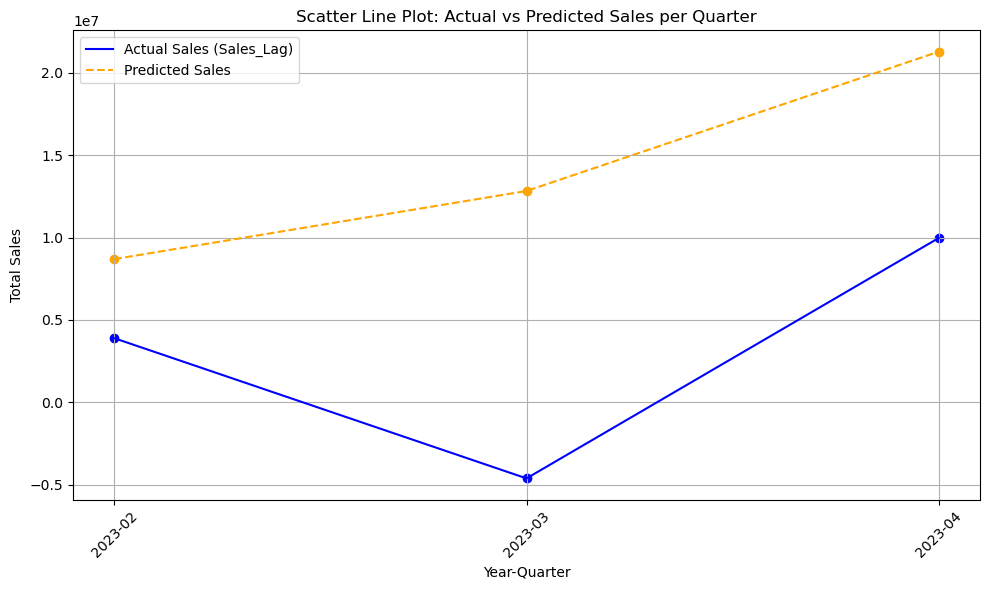

In [236]:
df = df.rename(columns={'family_encoded': 'family', 'sales_lag': 'Sales_Lag'})
df_final = df_final.rename(columns={'Prediction': 'Predicted_Sales'})

# Reset index to work with 'quarter_start'
df_reset = df.reset_index()
df_final_reset = df_final.reset_index()

# Group and sum sales by Year-Quarter
df_grouped = df_reset.groupby('Year-Quarter')['Sales_Lag'].sum().reset_index()
df_final_grouped = df_final_reset.groupby('Year-Quarter')['Predicted_Sales'].sum().reset_index()

# Merge on Year-Quarter
merged = pd.merge(df_grouped, df_final_grouped, on='Year-Quarter')

# Sort for plotting
merged = merged.sort_values('Year-Quarter')

# Plotting: scatter + line plot
plt.figure(figsize=(10, 6))

# Actual Sales
plt.plot(merged['Year-Quarter'], merged['Sales_Lag'], linestyle='-', color='blue', label='Actual Sales (Sales_Lag)')
plt.scatter(merged['Year-Quarter'], merged['Sales_Lag'], color='blue')

# Predicted Sales
plt.plot(merged['Year-Quarter'], merged['Predicted_Sales'], linestyle='--', color='orange', label='Predicted Sales')
plt.scatter(merged['Year-Quarter'], merged['Predicted_Sales'], color='orange')

# Decorations
plt.title("Scatter Line Plot: Actual vs Predicted Sales per Quarter")
plt.xlabel("Year-Quarter")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Calculating Actual Predicted Sales

In [239]:
# Ensure df_final is sorted correctly
df_final = df_final.sort_values(['family', 'Quarter'])

# Strip any spaces from column names (if there are any)
df_final.columns = df_final.columns.str.strip()

# Pivot the predictions: rows = family, columns = Quarter
pivot = df_final.pivot(index='family', columns='Quarter', values='Predicted_Sales')

# Apply your logic:
# Quarter 2 final prediction = prediction Q2 + prediction Q4
pivot['final_Q2'] = pivot[2] + pivot[4]
# Quarter 3 final prediction = previous + prediction Q3
pivot['final_Q3'] = pivot['final_Q2'] + pivot[3]
# Quarter 4 final prediction = previous + prediction Q4
pivot['final_Q4'] = pivot['final_Q3'] + pivot[4]

# Convert back to long format
final_df = pivot[['final_Q2', 'final_Q3', 'final_Q4']].reset_index()
final_df = final_df.melt(id_vars='family', 
                         value_vars=['final_Q2', 'final_Q3', 'final_Q4'],
                         var_name='Quarter', 
                         value_name='Final_Prediction')

# Extract quarter number from column names
final_df['Quarter'] = final_df['Quarter'].str.extract(r'final_Q(\d)').astype(int)

# Add constant year and quarter_start based on your original structure
final_df['Year'] = 2023
quarter_start_map = {2: '2023-04-01', 3: '2023-07-01', 4: '2023-10-01'}
final_df['quarter_start'] = final_df['Quarter'].map(quarter_start_map)

# Reorder columns to match your original df_final structure
final_df = final_df[['quarter_start', 'Year', 'Quarter', 'family', 'Final_Prediction']]


In [241]:
final_df

,quarter_start,Year,Quarter,family,Final_Prediction
0,2023-04-01,2023,2,0,"-2,479.7427"
1,2023-04-01,2023,2,1,"1,189.3288"
2,2023-04-01,2023,2,2,"14,124.9114"
3,2023-04-01,2023,2,3,"10,209,675.3711"
4,2023-04-01,2023,2,4,0.0000
...,...,...,...,...,...
94,2023-10-01,2023,4,28,"-768,937.0525"
95,2023-10-01,2023,4,29,-558.4717
96,2023-10-01,2023,4,30,"38,668,590.2551"
97,2023-10-01,2023,4,31,"60,260.5812"


## Replacing Negative Sales from 0

In [244]:
# Replace negative Final_Prediction values with 0
final_df.loc[final_df['Final_Prediction'] < 0, 'Final_Prediction'] = 0
final_df

,quarter_start,Year,Quarter,family,Final_Prediction
0,2023-04-01,2023,2,0,0.0000
1,2023-04-01,2023,2,1,"1,189.3288"
2,2023-04-01,2023,2,2,"14,124.9114"
3,2023-04-01,2023,2,3,"10,209,675.3711"
4,2023-04-01,2023,2,4,0.0000
...,...,...,...,...,...
94,2023-10-01,2023,4,28,0.0000
95,2023-10-01,2023,4,29,0.0000
96,2023-10-01,2023,4,30,"38,668,590.2551"
97,2023-10-01,2023,4,31,"60,260.5812"
